# Breast cancer handling with QNN
- based upon material shared during IBM quantum explorer's program 2022
- also integrated: https://tampapath.medium.com/classifying-breast-cancer-with-quantum-machine-learning-using-ibm-qiskit-80ce81021c36
- also integrated: https://tampapath.medium.com/classifying-breast-cancer-with-quantum-machine-learning-using-ibm-qiskit-c7c9f6575a00

In [2]:
# some imports
import matplotlib.pyplot as plt
import numpy as np
import pylatexenc

import pandas as pd

from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.circuit import QuantumCircuit
from qiskit_algorithms.utils  import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
#from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

from IPython.display import clear_output

algorithm_globals.random_seed = 42

## Prepare dataset

In [3]:
from sklearn.datasets import load_breast_cancer

bc_data = load_breast_cancer()

In [4]:
print(bc_data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [5]:
# this dataset has 30 features -> we have to cleanup and reduce
df = pd.DataFrame(data=bc_data.data, columns=bc_data.feature_names)
df['target'] = bc_data.target

d = df
X = d.drop(['target'], axis=1)
y = d['target']

In [6]:
# standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [7]:
# reduce feature dimensionality with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.44272026 0.18971182 0.09393163 0.06602135]


In [8]:
# normalize
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

In [9]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    X, y, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [10]:
#breast feature dimension
bc_feature_dim = train_features.shape[1]
print(bc_feature_dim)

4


In [11]:
## Build QNNCircuit with RealAmplitudes

In [12]:
feature_map = ZZFeatureMap(bc_feature_dim)
    
ansatz = RealAmplitudes(bc_feature_dim, entanglement='reverse_linear', reps=3)
print(ansatz)

# construct quantum circuit
#qc = QuantumCircuit(num_inputs)
#qc.append(feature_map, range(num_inputs))
#qc.append(ansatz, range(num_inputs))
#qc.decompose().draw(output="mpl", style="clifford", fold=20)

     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
«     ┌────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                       ├
«     │                                                                                                        │
«q_1: ┤1                                                                                                       ├
«     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11],θ[12],θ[13],θ[14],θ[15]) │
«q_2: ┤2                                                                                                       ├
«     │                                                                                                        │
«q_3: ┤3                                                                                                       ├
«     └──────────────────────────

In [71]:
circuit_qnn = QNNCircuit(num_qubits = bc_feature_dim, feature_map=feature_map, ansatz=ansatz)

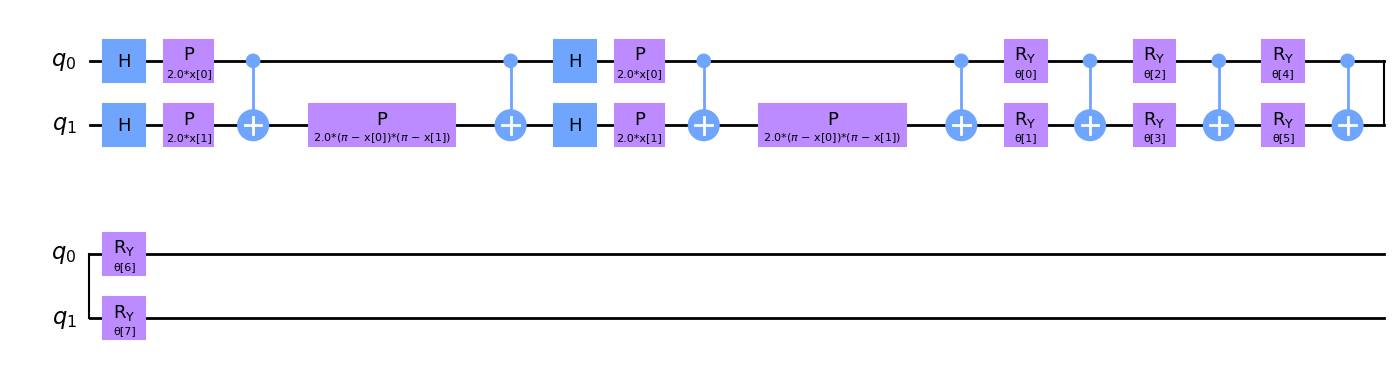

In [72]:
circuit_qnn.decompose().draw(output="mpl", style="clifford", fold=20)

In [73]:
print(test_labels)

333    1
273    1
201    0
178    1
85     0
      ..
179    1
192    1
246    1
211    1
72     0
Name: target, Length: 114, dtype: int64


In [18]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [15]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

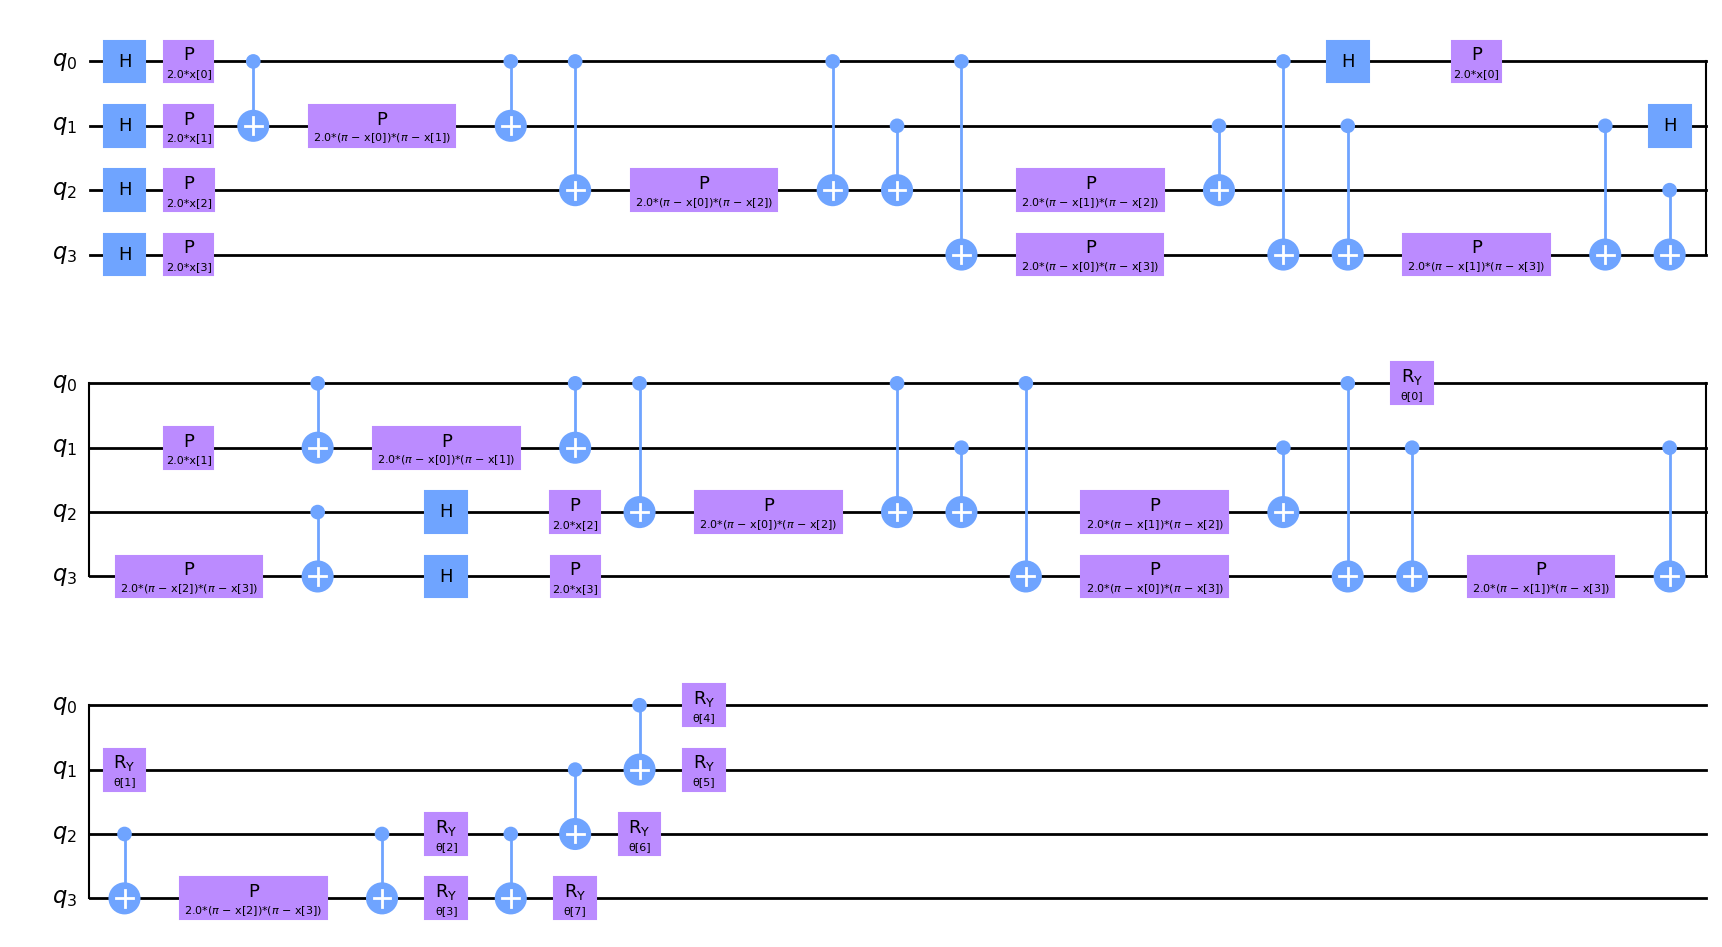

In [106]:
from qiskit_algorithms.optimizers import SPSA

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

output_shape = 2

# construct a quantum circuit from the default ZZFeatureMap feature map and a customized RealAmplitudes ansatz
qc = QNNCircuit(ansatz=RealAmplitudes(bc_feature_dim, reps=1))
qc.decompose().draw("mpl", style="clifford")

## Train QNNCircuit with SamplerQNN and no interpret function

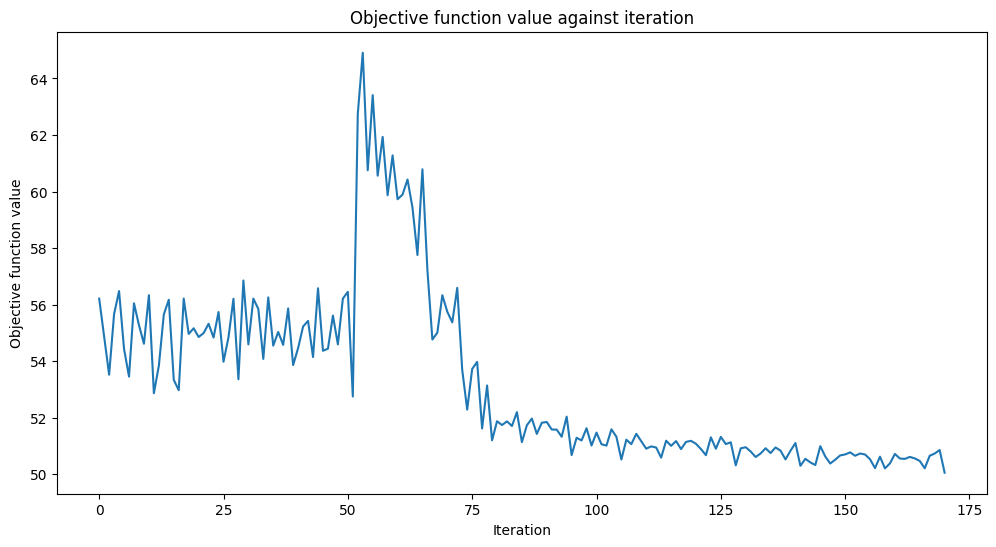

Score of breast cancer training data: 0.12280701754385964


In [107]:
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc, #circuit_qnn,
    #interpret=parity,
    output_shape=output_shape
)
# construct neural network classifier
sampler_classifier = NeuralNetworkClassifier(
    sampler_qnn, optimizer=SPSA(maxiter=60), callback=callback_graph
)

sampler_classifier.fit(train_features, train_labels)
y_predict = sampler_classifier.predict(test_features)
score_val = sampler_classifier.score(test_features, test_labels)

print(f'Score of breast cancer training data: {score_val}')

## Train QNNCircuit with SamplerQNN and interpret function and forward run

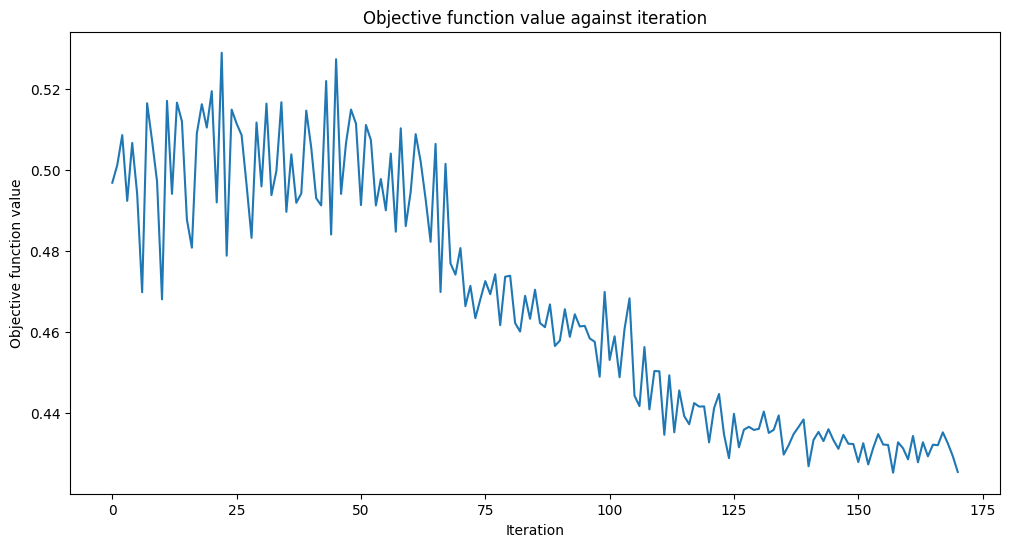

Score of breast cancer training data: 0.7192982456140351


In [103]:
# try sampler qnn with forward
from qiskit_algorithms.optimizers import SPSA

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

output_shape = 2

# construct a quantum circuit from the default ZZFeatureMap feature map and a customized RealAmplitudes ansatz
qc = QNNCircuit(ansatz=RealAmplitudes(bc_feature_dim, reps=1))
qc.draw("mpl", style="clifford")

# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc, #circuit_qnn,
    interpret=parity,
    output_shape=output_shape
)

sampler_qnn.forward(input_data=[1, 2, 3, 4], weights=[1, 2, 3, 4, 5, 6, 7, 8])

# construct neural network classifier
sampler_classifier = NeuralNetworkClassifier(
    sampler_qnn, optimizer=SPSA(maxiter=60), callback=callback_graph
)

sampler_classifier.fit(train_features, train_labels)
y_predict = sampler_classifier.predict(test_features)
score_val = sampler_classifier.score(test_features, test_labels)

print(f'Score of breast cancer training data: {score_val}')

## Try QNNCircuit (with EfficientSU2) and interpret function and without forward run

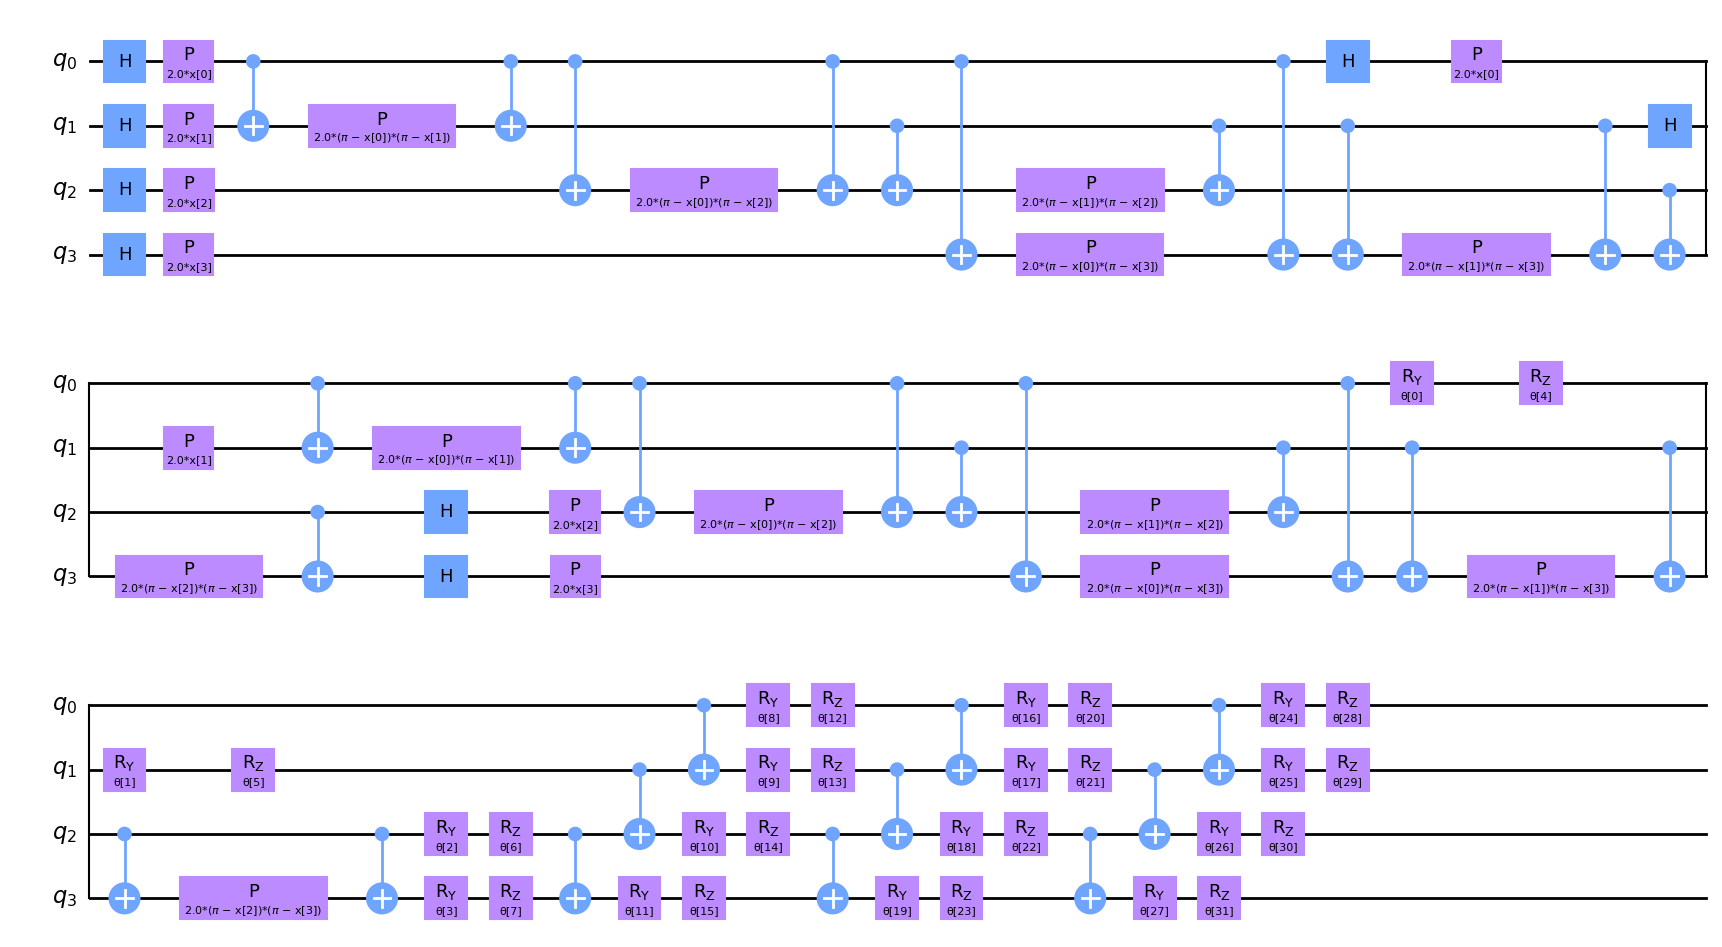

In [13]:
# try sampler qnn with forward
from qiskit.circuit.library import EfficientSU2

qc_su2 = QNNCircuit(ansatz=EfficientSU2(bc_feature_dim, reps=3))
qc_su2.decompose().draw("mpl", style="clifford")

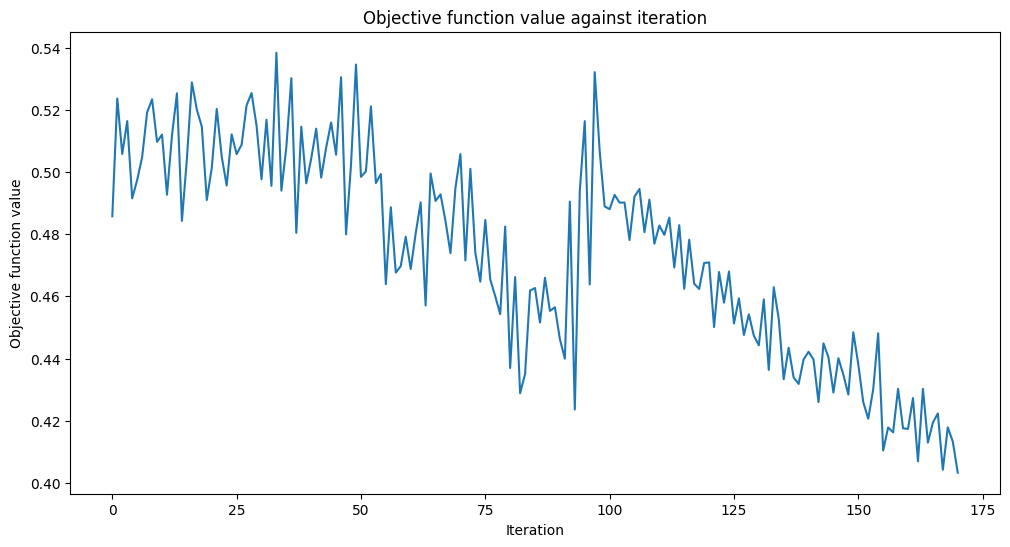

Score of breast cancer training data: 0.7105263157894737


In [19]:
from qiskit_algorithms.optimizers import SPSA

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

output_shape = 2

# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc_su2,
    interpret=parity,
    output_shape=output_shape
)

#sampler_qnn.forward(input_data=[1, 2, 3, 4], weights=[1, 2, 3, 4, 5, 6, 7, 8])

# construct neural network classifier
sampler_classifier = NeuralNetworkClassifier(
    sampler_qnn, optimizer=SPSA(maxiter=60), callback=callback_graph
)

sampler_classifier.fit(train_features, train_labels)
y_predict = sampler_classifier.predict(test_features)
score_val = sampler_classifier.score(test_features, test_labels)

print(f'Score of breast cancer training data: {score_val}')

## Try QNNCircuit (with EfficientSU2) and interpret function and without forward run extend number of iterations

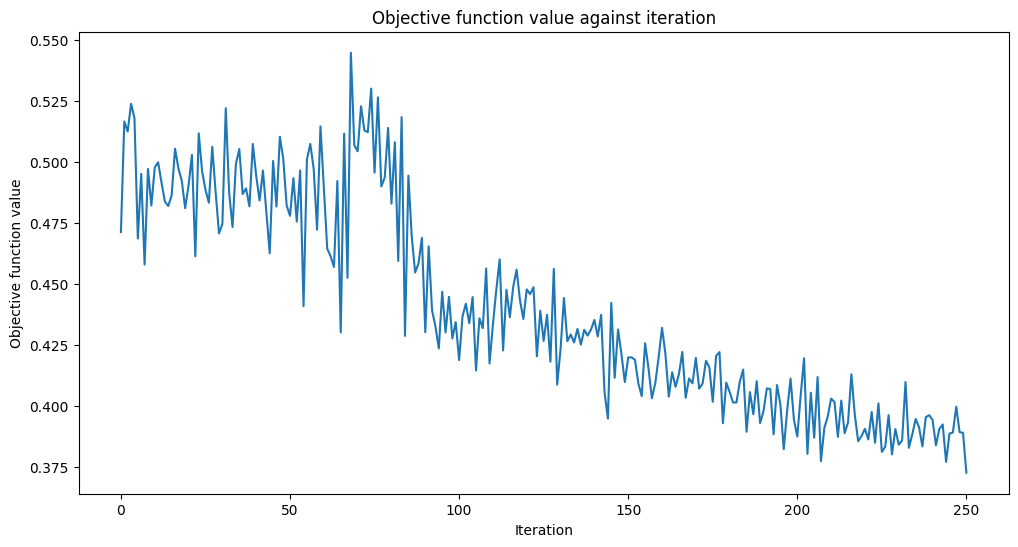

Score of breast cancer training data: 0.8157894736842105


In [20]:
from qiskit_algorithms.optimizers import SPSA

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

output_shape = 2

# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc_su2,
    interpret=parity,
    output_shape=output_shape
)

#sampler_qnn.forward(input_data=[1, 2, 3, 4], weights=[1, 2, 3, 4, 5, 6, 7, 8])

# construct neural network classifier
sampler_classifier = NeuralNetworkClassifier(
    sampler_qnn, optimizer=SPSA(maxiter=100), callback=callback_graph
)

sampler_classifier.fit(train_features, train_labels)
y_predict = sampler_classifier.predict(test_features)
score_val = sampler_classifier.score(test_features, test_labels)

print(f'Score of breast cancer training data: {score_val}')

## Use precompiled kernel (QSVC with ZZFeatureMap)

In [24]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
adhoc_feature_map = ZZFeatureMap(feature_dimension=bc_feature_dim, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

In [26]:
from qiskit_machine_learning.algorithms import QSVC
qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(train_features, train_labels)

qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.9473684210526315


## Try with VQC

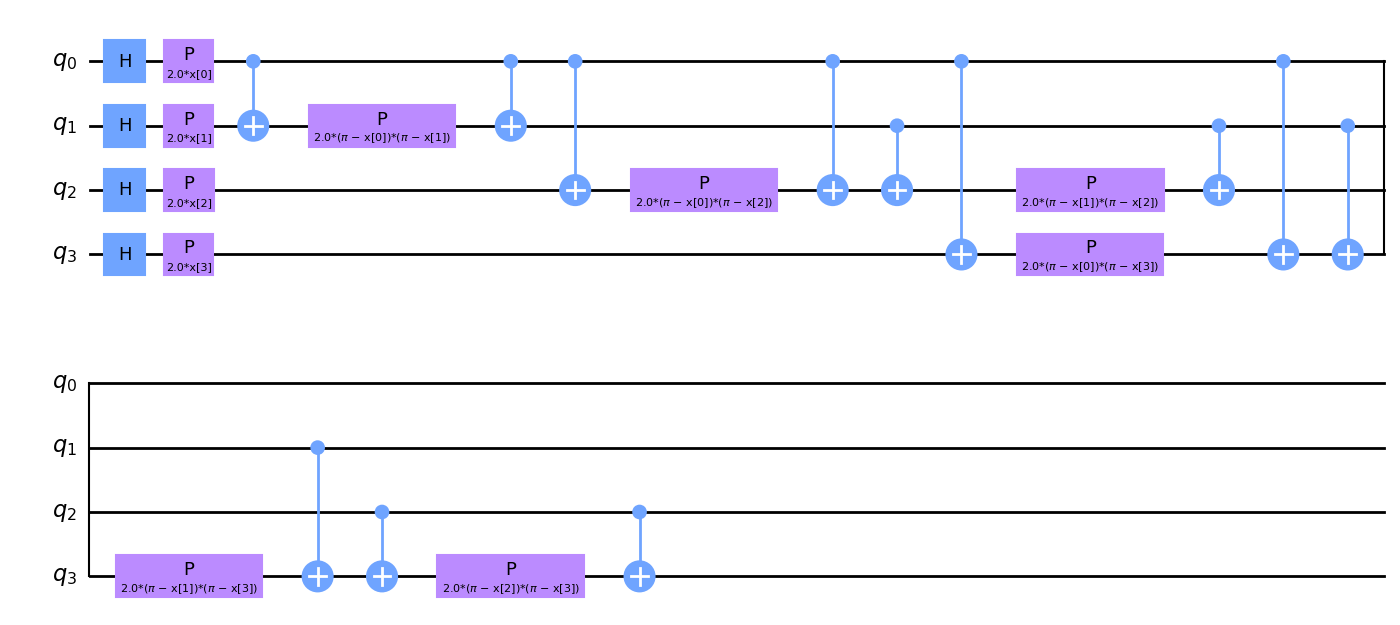

In [83]:
from qiskit.circuit.library import ZZFeatureMap

feature_map = ZZFeatureMap(feature_dimension=bc_feature_dim, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

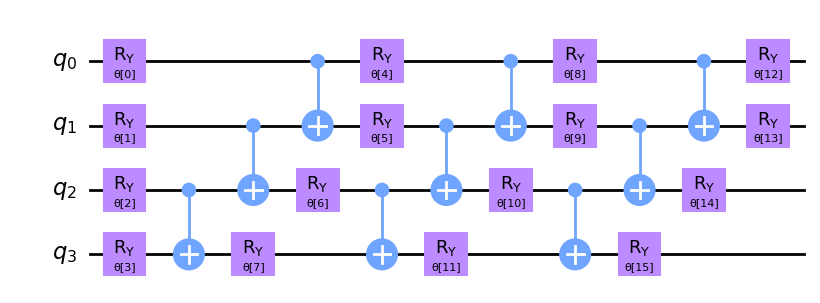

In [84]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=bc_feature_dim, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

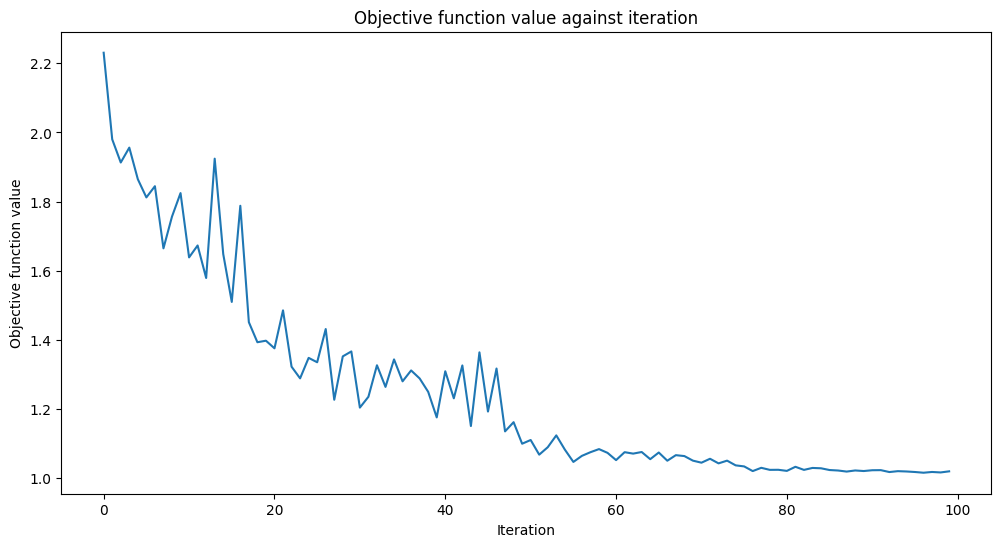

Training time: 252 seconds


In [99]:
import time
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler

optimizer = COBYLA(maxiter=100)
sampler = Sampler()

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
#vqc.fit(train_features, train_labels_oh)
vqc.fit(train_features, train_labels.array)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [100]:
# score classifier
vqc.score(train_features, train_labels)

0.7692307692307693

In [101]:
vqc.score(test_features, test_labels)

0.8508771929824561

## Classical SVC

In [39]:
from sklearn.svm import SVC

svc = SVC(probability=True)
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

In [40]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.97
Classical SVC on the test dataset:     0.97


## Compare SHAP values

In [41]:
import shap
shap.initjs()

In [43]:
# get shap of classic SVC
# explain all the predictions in the test set
explainer = shap.KernelExplainer(svc.predict_proba, train_features)
shap_values = explainer.shap_values(test_features)
shap.force_plot(explainer.expected_value[0], shap_values[0], test_features)

Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/114 [00:00<?, ?it/s]

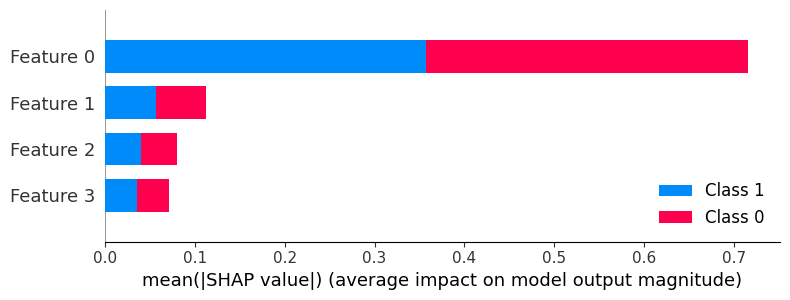

In [44]:
shap.summary_plot(shap_values, test_features)

In [46]:
# get shap of qsvc
# explain all the predictions in the test set
qsvc_explainer = shap.KernelExplainer(svc.predict_proba, train_features)
qsvc_shap_values = qsvc_explainer.shap_values(test_features)
shap.force_plot(qsvc_explainer.expected_value[0], qsvc_shap_values[0], test_features)

Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/114 [00:00<?, ?it/s]

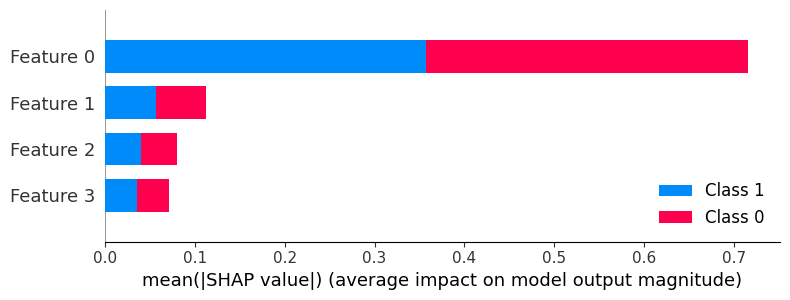

In [47]:
shap.summary_plot(qsvc_shap_values, test_features)